<a href="https://colab.research.google.com/github/John-D-Boom/CompVision/blob/load_all_data_before/testing_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook checks that I can load the dataset, load torch, syncing with GitHub, etc.


In [ ]:
import torch
import numpy
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import os
import shutil
from skimage import io
from skimage.color import gray2rgb

In [ ]:
# import zipfile
# with zipfile.ZipFile('/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/MLMI/CompVision/')

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/MLMI/CompVision/heatmap.csv')

In [ ]:
# # importing the "tarfile" module
# import tarfile

# # open file
# file = tarfile.open('/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200-copy.tar.gz')

# # extracting file
# file.extractall('/content/drive/MyDrive/MLMI/CompVision')

# file.close()


In [ ]:
def checkFolderSetup(root_dir, expected_num):
    for root, dirs, files in os.walk(root_dir):
      # For each subfolder in the root directory
        for d in dirs:
          # Get the full path to the subfolder
            subfolder_path = os.path.join(root, d)
          # Count the number of entries in the subfolder
            num_entries = len(os.listdir(subfolder_path))
          # Check if the number of entries in the subfolder is equal to n
            try:
                assert num_entries == expected_num 
            except:
                print(f'{root_dir} has error in directory {d}')
    print(f'Checked all folders in {root_dir}')



In [ ]:
# test_dir = '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/test'
# val_dir =  '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/val'
# train_dir =  '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/train'
# checkFolderSetup(train_dir, 500)
# checkFolderSetup(test_dir, 25)
# checkFolderSetup(val_dir, 25)


In [ ]:
# shutil.copytree('/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200', '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200-backup')

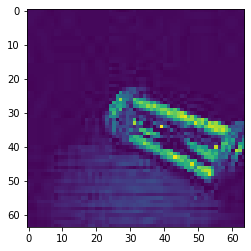

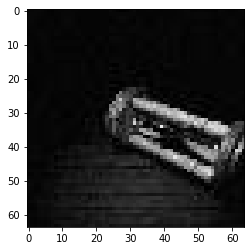

In [ ]:
from skimage import io
path = '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/train/n03544143/n03544143_369.JPEG'
img = io.imread(path)
plt.figure(0)
plt.imshow(img)
plt.figure(1)
plt.imshow(gray2rgb(img))

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from skimage import io, transform
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116


In [ ]:
class siameseDataset(Dataset):
    
    def __init__(self, csv_file, transform=None, device = "cuda"):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_frame = pd.read_csv(csv_file, names = ["Image1 Path", "Label1", "Image2 Path", "Label2"])[:100]
        all_data = torch.zeros((3,len(self.images_frame)))
        all_tensor = torch.zeros(0) #temp value
        
        train_csv = '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/train.csv'
        # if(csv_file == train_csv):
            # print('is train')
            # self.sim_df = self.images_frame[0:80000:2]
            # self.dif_df = self.images_frame[80000:len(self.images_frame):10]
            # self.images_frame = pd.concat([self.sim_df, self.dif_df])

        #Unpack data into tensor to load into csv
        for idx in range(len(self.images_frame)):
            
            defaultPathStart = '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/'
            img_path1 = self.images_frame.iloc[idx, 0].split('/tiny-imagenet-200/')[1] #Unpacks path and fixes to be compatible with google drive
            img_path1 = defaultPathStart + img_path1
            label1 = self.images_frame.iloc[idx, 1]
            
            img_path2 = self.images_frame.iloc[idx, 2].split('/tiny-imagenet-200/')[1] #Unpacks path and fixes to be compatible with google drive
            img_path2 = defaultPathStart + img_path2
            label2 = self.images_frame.iloc[idx, 3]

            image1 = io.imread(img_path1)
            image2 = io.imread(img_path2)

            #Check shapes and enforce RGB

            if (len(image1.shape) != 3):
                # print("bad image1")
                image1 = gray2rgb(image1)
            if (len(image2.shape) != 3):
                # print("bad image2")
                image2 = gray2rgb(image2)


            flag = ((label1==label2)*2 -1)

            #tensors must all have the same shape, so if I want to send everything to gpu in one tensor I have to pad. 
            #Sucky but I don't expect memory issues
            flag_tensor = flag_arr = torch.full((64,64,3), flag)

            #make a 3, 64, 64 sample_tensor with 
            # 0: image1
            # 1: image2
            # 2: a 64x64 array of the flag (RIP)
            sample_tensor = torch.stack((torch.tensor(image1),torch.tensor(image2),flag_tensor))
            # print("sample shape", sample_tensor.shape)
            # print("all shape", all_tensor.shape)
            #add this tensor to the list
            if idx == 0:
                all_tensor = sample_tensor
                continue
            elif idx == 1:
                all_tensor = all_tensor.unsqueeze(dim=0)
            else:
                all_tensor = torch.cat((all_tensor, sample_tensor.unsqueeze(dim=0)))
        
        self.images_frame = all_tensor
        self.images_frame.to(device)
        self.transform = transform

    def __len__(self):
        return len(self.images_frame)

    def __getitem__(self, idx):
        
        # print('getting item')
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.images_frame[idx]
        image1 = sample[0]
        image2 = sample[1]
        flag = sample[2][0,0]
            
        # print('imread successful')
        print(image1.shape)
        print(image2.shape)
        print(flag.shape)
        if self.transform:
            try:
                image1 = self.transform(image1)
                image2 = self.transform(image2)
                # print('transforming')
            except:
                print('ERROR in transforming')
                 

        sample = {'image1': image1, 'image2': image2, 'flag': flag}

        return sample

In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset ***Dimensions of last layer***
num_classes = 256

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for 
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_similar_acc_history = []
    val_different_acc_history = []
    
    best_similar_model_wts = copy.deepcopy(model.state_dict())
    best_different_model_wts = copy.deepcopy(model.state_dict())

    best_similar_loss = 1e8
    best_different_loss = 1e8

    training_grayscale_errors = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        epoch_start = time.time()
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val_different', 'val_similar']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # print("just before dataloader")
            for batch, obj in enumerate(dataloaders[phase]):
                print(batch, "/", len(dataloaders[phase]))
                try:
                    # print("trying unpack obj")
                    image1 = obj["image1"]
                    image2 = obj["image2"]
                    flag = obj["flag"]
                except:
                    training_grayscale_errors += 1
                    continue

                image1 = image1.to(device)
                image2 = image2.to(device)
                flag = flag.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.

                    #***ignoring inception model rn
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        # print('running model1')
                        output1 = model(image1)
                        # print('running model2')
                        output2 = model(image2)

                        #***CRITERION HARDCODED AS COSINEEMBEDDINGLOSS***
                        criterion = nn.CosineEmbeddingLoss(margin=0.0, reduction= 'mean')

                        loss = criterion(output1, output2, flag)
                        # print("loss:",loss)
                    # _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        
                        optimizer.step()
                        # print('updated weights')
                    
                # statistics
                running_loss += loss.item() * output1.size(0) #multiplies scalar loss by the number in this batch
                # running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = float(running_corrects) / len(dataloaders[phase].dataset)
            epoch_time = time.time() - epoch_start
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train':
                print('Epoch complete in {:.0f}m {:.0f}s'.format(epoch_time // 60, epoch_time % 60))


            # deep copy the model if in a validation mode
            if phase == 'val_similar' and epoch_loss < best_similar_loss:
                best_similar_acc = epoch_acc
                best_similar_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_similar_model_wts, '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/models/first_resnet18/best_sim_weights')
            if phase == 'val_similar':
                val_similar_acc_history.append(epoch_acc)
            if phase == 'val_different' and epoch_acc < best_different_loss:
                best_different_acc = epoch_acc
                best_different_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_different_model_wts, '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/models/first_resnet18/best_dif_weights')

            if phase == 'val_different':
                val_different_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_similar_acc))
    print('Number of Greyscale Errors:', training_grayscale_errors)

    # load best model weights
  
    

    return best_similar_model_wts, best_different_model_wts, val_similar_acc_history, val_different_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets


train_csv = '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/train.csv'
val_different_csv = '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/val_different.csv'
val_similar_csv = '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/val_similar.csv'

siamese_datasets = {}
siamese_datasets["train"] = siameseDataset(csv_file= train_csv, transform=data_transforms['train'])
siamese_datasets["val_different"] = siameseDataset(csv_file= val_different_csv, transform=data_transforms['val'])
siamese_datasets["val_similar"] = siameseDataset(csv_file= val_similar_csv, transform=data_transforms['val'])



cuda:0
Initializing Datasets and Dataloaders...


In [ ]:
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(siamese_datasets[x], batch_size=batch_size, shuffle=True, num_workers = 2, pin_memory = True) for x in ['train', 'val_different', 'val_similar']}


In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [ ]:
#TRAIN MODEL
# Setup the loss fxn
#***NOT CURRENTLY USING THIS CRITERION. HARD CODED IN TRAIN AS COSINEEMBEDDINGLOSS
criterion = nn.CrossEntropyLoss()

# Train and evaluate
best_model_sim_weights, best_model_dif_weights, sim_hist, dif_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

#save weights
torch.save(best_model_sim_weights, '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/models/first_resnet18/best_sim_weights')
torch.save(best_model_dif_weights, '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/models/first_resnet18/best_dif_weights')
np.savetxt('/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/models/first_resnet18/sim_hist.txt', np.array(sim_hist))
np.savetxt('/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/models/first_resnet18/dif_hist.txt', np.array(dif_hist))

Epoch 0/9
----------
torch.Size([64, 64, 3])torch.Size([64, 64, 3])

torch.Size([64, 64, 3])torch.Size([64, 64, 3])

torch.Size([3])torch.Size([3])
ERROR in transforming

ERROR in transformingtorch.Size([64, 64, 3])
torch.Size([64, 64, 3])

torch.Size([64, 64, 3])torch.Size([64, 64, 3])
torch.Size([3])

torch.Size([3])
ERROR in transformingERROR in transforming

torch.Size([64, 64, 3])torch.Size([64, 64, 3])

torch.Size([64, 64, 3])torch.Size([64, 64, 3])
torch.Size([3])
ERROR in transforming

torch.Size([3])torch.Size([64, 64, 3])
torch.Size([64, 64, 3])

ERROR in transforming
torch.Size([3])torch.Size([64, 64, 3])

ERROR in transformingtorch.Size([64, 64, 3])
torch.Size([3])

torch.Size([64, 64, 3])ERROR in transforming
torch.Size([64, 64, 3])

torch.Size([3])torch.Size([64, 64, 3])

torch.Size([64, 64, 3])

torch.Size([3])ERROR in transformingERROR in transforming

torch.Size([64, 64, 3])torch.Size([64, 64, 3])

torch.Size([64, 64, 3])torch.Size([64, 64, 3])

torch.Size([3])torch.Si

RuntimeError: ignored

In [ ]:
# Initialize the non-pretrained version of the model used for this run
# scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
# scratch_model = scratch_model.to(device)
# scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
# scratch_criterion = nn.CrossEntropyLoss()
# _,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
# shist = []

ohist = [h.cpu().numpy() for h in hist]
# shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
# plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
from skimage import io
path = '/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/train/n03544143/n03544143_435.JPEG'
img = io.imread(path)
plt.imshow(img)
print(img.shape)

In [ ]:
sim_hist = np.loadtxt('/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/models/first_resnet18/sim_hist.txt')
dif_hist = np.loadtxt('/content/drive/MyDrive/MLMI/CompVision/tiny-imagenet-200/models/first_resnet18/dif_hist.txt')
plt.figure(0)
plt.plot(sim_hist, 'r.')
plt.plot(dif_hist, 'g--')